<a href="https://colab.research.google.com/github/KaikeGM/Challenge-Telecom-X-Data-Science-Parte-2/blob/main/TelecomX_BR_Parte_2_modificado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🛠️ Preparação dos Dados**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import pickle
import os
from urllib.request import urlopen

In [ ]:
# Carregamento dos dados
url = 'https://raw.githubusercontent.com/KaikeGM/TelecomX_BR/refs/heads/main/dados_prontos.csv'
dados = pd.read_csv(url)

# Adicionando a feature 'Tenure' (Tempo de Contrato em meses)
# Esta é uma feature crucial para Churn. Evitamos a divisão por zero
# substituindo zeros em 'Charges.Monthly' por NaN antes do cálculo e removendo a linha.
dados['Charges.Total'] = pd.to_numeric(dados['Charges.Total'], errors='coerce')
dados['Charges.Monthly'] = pd.to_numeric(dados['Charges.Monthly'], errors='coerce')

# Criação da feature Tenure
# Assumimos que o Charges.Total é a soma dos Charges.Monthly ao longo do tempo.
# Tratamento de Charges.Monthly = 0 para evitar erro na divisão.
dados['Tenure'] = dados['Charges.Total'] / dados['Charges.Monthly'].replace(0, np.nan)

# Remoção de NaNs criados (principalmente de Tenure)
dados = dados.dropna(subset=['Tenure']).reset_index(drop=True)

print("Visão das 5 primeiras linhas (com Tenure calculado):")
print(dados.head())
print("\nDimensões do dataset:", dados.shape)
print("\nTipos de dados:")
dados.info()

Visão das 5 primeiras linhas (com Tenure calculado):
   Churn        Contract     PaymentMethod PaperlessBilling  Charges.Monthly  \
0      0        one year      mailed check              yes             65.6   
1      0  month-to-month      mailed check               no             59.9   
2      1  month-to-month  electronic check              yes             73.9   
3      1  month-to-month  electronic check              yes             98.0   
4      1  month-to-month      mailed check              yes             83.9   

   Charges.Total InternetService OnlineSecurity TechSupport StreamingTV  \
0         593.30             dsl             no         yes         yes   
1         542.40             dsl             no          no          no   
2         280.85     fiber optic             no          no          no   
3        1237.85     fiber optic             no          no         yes   
4         267.40     fiber optic             no         yes         yes   

  StreamingMovi

In [ ]:
variaveis_categoricas = ['Contract', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'StreamingMovies']

In [ ]:
X = dados.drop(['Churn'], axis=1)
y = dados['Churn']

# **🎯 Correlação e Seleção de Variáveis**

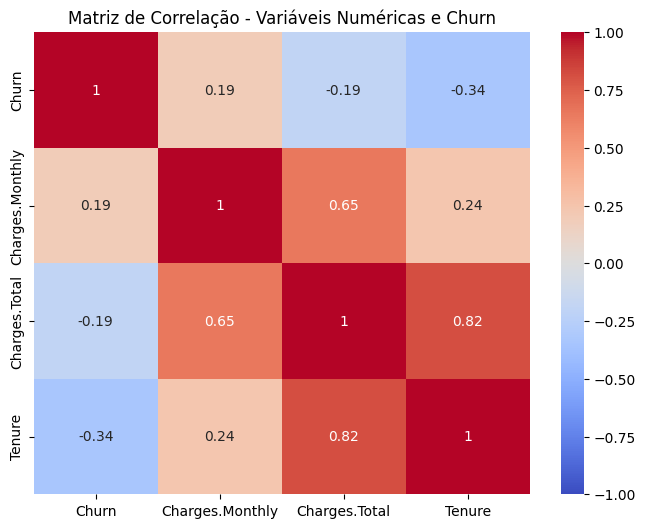

Correlações com Churn:
Churn              1.000000
Charges.Monthly    0.193136
Charges.Total     -0.189112
Tenure            -0.341369
Name: Churn, dtype: float64


In [ ]:
# Selecionar apenas variáveis numéricas e Churn
numeric_cols = ['Churn', 'Charges.Monthly', 'Charges.Total', 'Tenure']
data_numeric = dados[numeric_cols]

# Calcular a matriz de correlação
corr_matrix = data_numeric.corr()

# Plotar heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlação - Variáveis Numéricas e Churn')
plt.show()

# Exibir correlações com Churn em ordem decrescente
print("Correlações com Churn:")
print(corr_matrix['Churn'].sort_values(ascending=False))

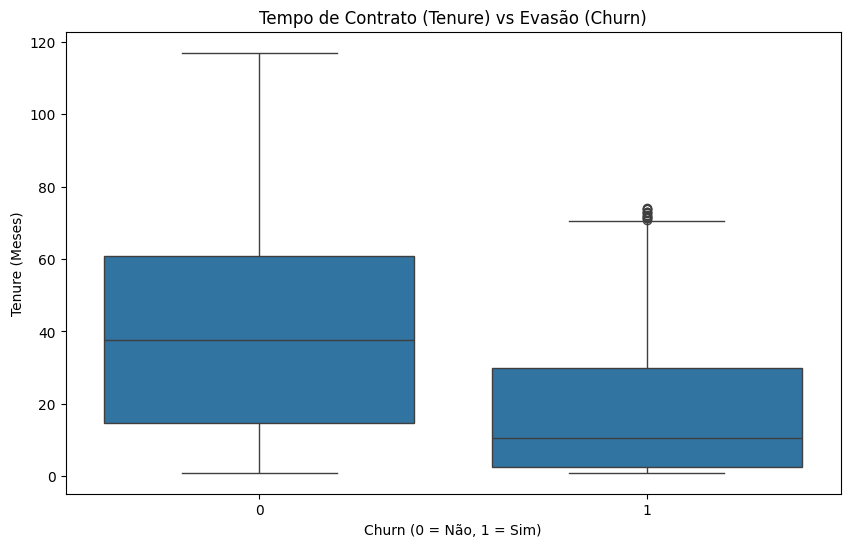


Médias de Tenure por Churn:
Churn 0: 37.6891 meses
Churn 1: 18.3994 meses


In [ ]:
# Criar boxplot para visualizar Tenure vs Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='Tenure', data=dados, order=[0, 1])
plt.title('Tempo de Contrato (Tenure) vs Evasão (Churn)')
plt.xlabel('Churn (0 = Não, 1 = Sim)')
plt.ylabel('Tenure (Meses)')
plt.show()

# Exibir estatísticas para ordenação (ex.: médias de Tenure por Churn)
stats = dados.groupby('Churn')['Tenure'].mean().sort_values(ascending=False)
print("\nMédias de Tenure por Churn:")
for churn, tenure in stats.items():
    print(f"Churn {churn}: {tenure:.4f} meses")

In [ ]:
# Verificar o desbalanceamento da variável target (Churn)
churn_counts = dados['Churn'].value_counts()
print("Distribuição da Variável Target (Churn):")
print(churn_counts)
print(f"Proporção Churn (1): {churn_counts[1] / churn_counts.sum():.2f}")
print(f"Proporção Não-Churn (0): {churn_counts[0] / churn_counts.sum():.2f}")

Distribuição da Variável Target (Churn):
Churn
0    5367
1    1823
Name: count, dtype: int64
Proporção Churn (1): 0.25
Proporção Não-Churn (0): 0.75


In [ ]:
# 1. Binary Encoding (manual) para 'PaperlessBilling'
# Transformação para binário (0 e 1)
dados['PaperlessBilling'] = dados['PaperlessBilling'].replace({'no': 0, 'yes': 1}).astype(np.int64)

# 2. One-Hot Encoding para as demais categóricas
variaveis_categoricas = ['Contract', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'StreamingMovies']
# Adicionando 'Tenure' como categórica temporária para o get_dummies (será tratada como numérica)
dados_encoded = pd.get_dummies(data=dados.drop(columns=['Charges.Monthly', 'Charges.Total']),
                               columns=variaveis_categoricas,
                               dtype=int)

# 3. Reagrupando o DataFrame final
# O Charges.Total e Charges.Monthly foram dropados anteriormente e serão incluídos novamente
# junto com Tenure, pois são importantes.
dados_final = pd.concat([dados_encoded, dados[['Charges.Monthly', 'Charges.Total']]], axis=1)

# Reorganizando a ordem das colunas para colocar o Churn na frente (opcional)
cols = ['Churn'] + [col for col in dados_final.columns if col != 'Churn']
dados_final = dados_final[cols]

# Separando X e Y
X = dados_final.drop(['Churn'], axis=1)
y = dados_final['Churn']

# Visualizando as colunas após One-Hot Encoding
print("\nColunas de Features (X) após encoding:")
print(X.columns.tolist())


Colunas de Features (X) após encoding:
['PaperlessBilling', 'Tenure', 'Contract_month-to-month', 'Contract_one year', 'Contract_two year', 'PaymentMethod_bank transfer (automatic)', 'PaymentMethod_credit card (automatic)', 'PaymentMethod_electronic check', 'PaymentMethod_mailed check', 'InternetService_dsl', 'InternetService_fiber optic', 'InternetService_no', 'OnlineSecurity_no', 'OnlineSecurity_no internet service', 'OnlineSecurity_yes', 'TechSupport_no', 'TechSupport_no internet service', 'TechSupport_yes', 'StreamingTV_no', 'StreamingTV_no internet service', 'StreamingTV_yes', 'StreamingMovies_no', 'StreamingMovies_no internet service', 'StreamingMovies_yes', 'Charges.Monthly', 'Charges.Total']


/tmp/ipython-input-465842345.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dados['PaperlessBilling'] = dados['PaperlessBilling'].replace({'no': 0, 'yes': 1}).astype(np.int64)


# **🤖 Modelagem Preditiva**

Top 10 features selecionadas: ['Tenure', 'Charges.Total', 'Charges.Monthly', 'Contract_month-to-month', 'OnlineSecurity_no', 'Contract_two year', 'TechSupport_no', 'InternetService_fiber optic', 'PaymentMethod_electronic check', 'PaperlessBilling']


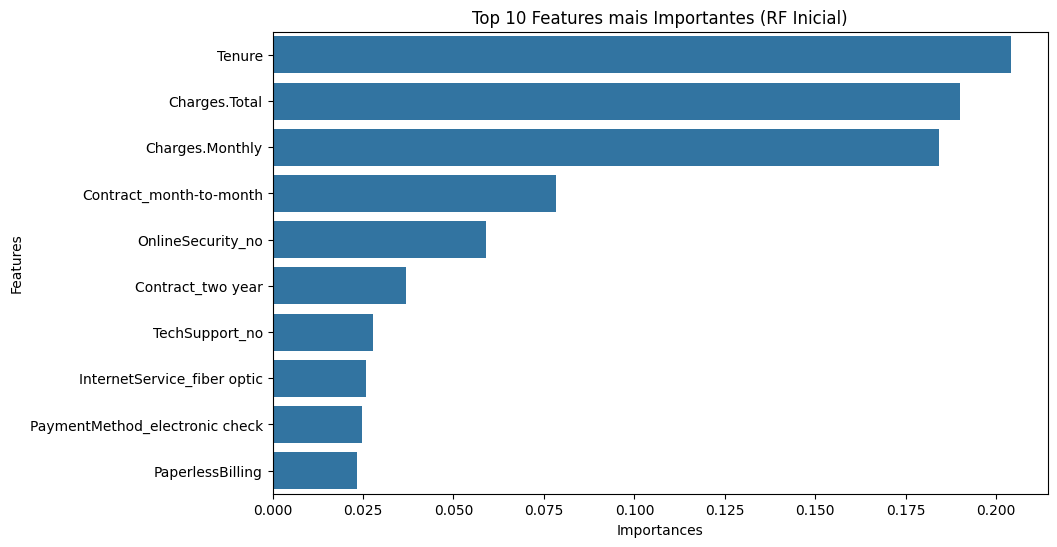

In [ ]:
# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Modelo inicial (usando class_weight='balanced' para compensar o desbalanceamento)
modelo_inicial = RandomForestClassifier(random_state=42, class_weight='balanced')
modelo_inicial.fit(X_train, y_train)

# Coletando importâncias
importances = modelo_inicial.feature_importances_

feature_importances = pd.DataFrame({
    'Features': X_train.columns,
    'Importances': importances
}).sort_values('Importances', ascending=False)

# Selecionando o Top 10
top_features = feature_importances['Features'].head(10).tolist()
print(f"Top 10 features selecionadas: {top_features}")

# Filtrando os datasets de treino e teste
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Plotando as 10 principais features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Features', data=feature_importances.head(10))
plt.title("Top 10 Features mais Importantes (RF Inicial)")
plt.show()

In [ ]:
# Pipelines de balanceamento
# BorderlineSMOTE: Tática de oversampling que gera amostras sintéticas focando nas fronteiras das classes.
smote = BorderlineSMOTE(random_state=42, kind='borderline-1') # kind='borderline-1' é um bom ponto de partida
# NearMiss: Tática de undersampling que remove amostras da classe majoritária com base na distância da classe minoritária.
near_miss = NearMiss(version=3)

# Random Forest Model (class_weight='balanced' ajusta os pesos inversamente à frequência)
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
pipeline_rf_oversample = imbpipeline([('oversample', smote), ('arvore', rf_model)])
pipeline_rf_undersample = imbpipeline([('undersample', near_miss), ('arvore', rf_model)])

# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
pipeline_dt_oversample = imbpipeline([('oversample', smote), ('arvore', dt_model)])
pipeline_dt_undersample = imbpipeline([('undersample', near_miss), ('arvore', dt_model)])

# Métrica de avaliação e K-Fold Estratificado (SKF)
# Foco em Recall/F1/ROC AUC, que são robustas para classes desbalanceadas.
scoring = ['recall', 'f1', 'roc_auc', 'precision']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def intervalo_conf(resultados, tipo):
    print(f"\n--- {tipo} ---")
    for metric in scoring:
        scores = resultados[f'test_{metric}']
        media = scores.mean()
        dp = scores.std()
        lower = max(0, media - 2*dp)
        upper = min(1, media + 2*dp)
        print(f"{metric.capitalize()}: Média={media:.4f}, IC=[{lower:.4f}, {upper:.4f}]")

def plot_intervalo_conf(df_resultados):
    """Plota gráfico de intervalo de confiança."""
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_resultados, x='Métrica', y='Média', hue='Técnica', ci=None)
    for i, row in df_resultados.iterrows():
        plt.plot([i % len(df_resultados['Métrica'].unique()), i % len(df_resultados['Métrica'].unique())],
                 [row['IC Inferior'], row['IC Superior']], color='black', linewidth=2)
    plt.title("Médias e Intervalos de Confiança")
    plt.ylim(0, 1)
    plt.legend(title='Técnica')
    plt.show()

def intervalo_conf_df(resultados, tipo, scoring):
    """Gera DataFrame com média e intervalo de confiança das métricas."""
    dados = []
    for metric in scoring:
        scores = resultados[f'test_{metric}']
        media = scores.mean()
        desvio_padrao = scores.std()
        lower = max(0, media - 2 * desvio_padrao)
        upper = min(1, media + 2 * desvio_padrao)
        dados.append({
            'Técnica': tipo,
            'Métrica': metric,
            'Média': round(media, 4),
            'IC Inferior': round(lower, 4),
            'IC Superior': round(upper, 4)
        })
    return pd.DataFrame(dados)

def plot_confusion_matrix_and_roc(model, X_test, y_test):
  """Plota matriz de confusão e curva ROC."""
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:, 1]

  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  # Matriz de confusão
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
  axes[0].set_title("Matriz de Confusão")
  axes[0].set_xlabel("Previsto")
  axes[0].set_ylabel("Real")

  # Curva ROC
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)
  axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
  axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
  axes[1].set_title("Curva ROC")
  axes[1].set_xlabel("Falso Positivo")
  axes[1].set_ylabel("Verdadeiro Positivo")
  axes[1].legend()

  plt.show()

def avaliar_varios_thresholds(modelo, X_test, y_test, thresholds=np.arange(0.1, 1.0, 0.1)):
    resultados = []

    # Probabilidades da classe positiva
    probs = modelo.predict_proba(X_test)[:, 1]

    # Avaliação em diferentes thresholds
    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        acc = accuracy_score(y_test, preds)
        resultados.append({
            'threshold': thr,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': acc
        })

    # Criar DataFrame com os resultados
    df_resultados = pd.DataFrame(resultados)

    # Plotar gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(df_resultados['threshold'], df_resultados['precision'], marker='o', label='Precision')
    plt.plot(df_resultados['threshold'], df_resultados['recall'], marker='o', label='Recall')
    plt.plot(df_resultados['threshold'], df_resultados['f1_score'], marker='o', label='F1 Score')
    plt.plot(df_resultados['threshold'], df_resultados['accuracy'], marker='o', label='Accuracy')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Métricas vs Threshold')
    plt.grid(True)
    plt.legend()
    plt.show()

    return df_resultados


--- RandomForest Oversampling (Inicial) ---
Recall: Média=0.5980, IC=[0.5806, 0.6153]
F1: Média=0.5214, IC=[0.5066, 0.5362]
Roc_auc: Média=0.7755, IC=[0.7637, 0.7874]
Precision: Média=0.4623, IC=[0.4443, 0.4803]


/tmp/ipython-input-3056284674.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_resultados, x='Métrica', y='Média', hue='Técnica', ci=None)


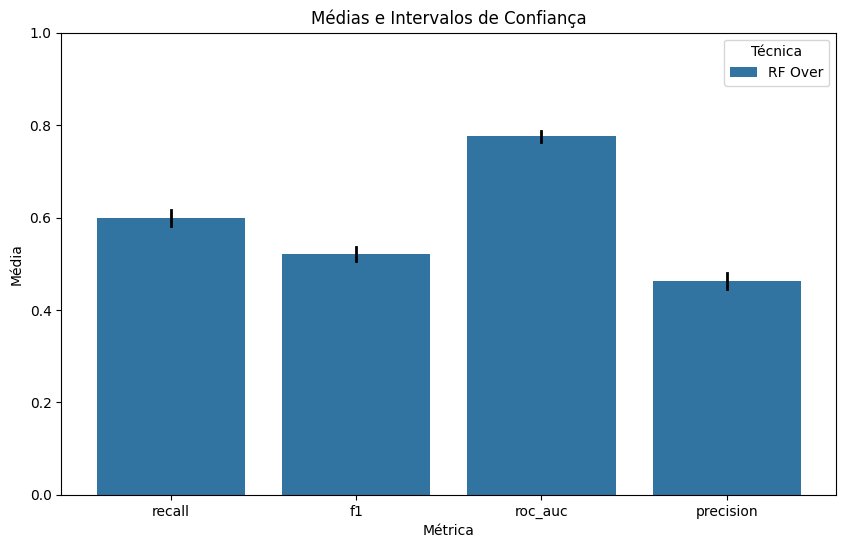


--- RandomForest Undersampling (Inicial) ---
Recall: Média=0.6622, IC=[0.6015, 0.7230]
F1: Média=0.5538, IC=[0.5226, 0.5851]
Roc_auc: Média=0.7714, IC=[0.7497, 0.7932]
Precision: Média=0.4762, IC=[0.4587, 0.4936]


/tmp/ipython-input-3056284674.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_resultados, x='Métrica', y='Média', hue='Técnica', ci=None)


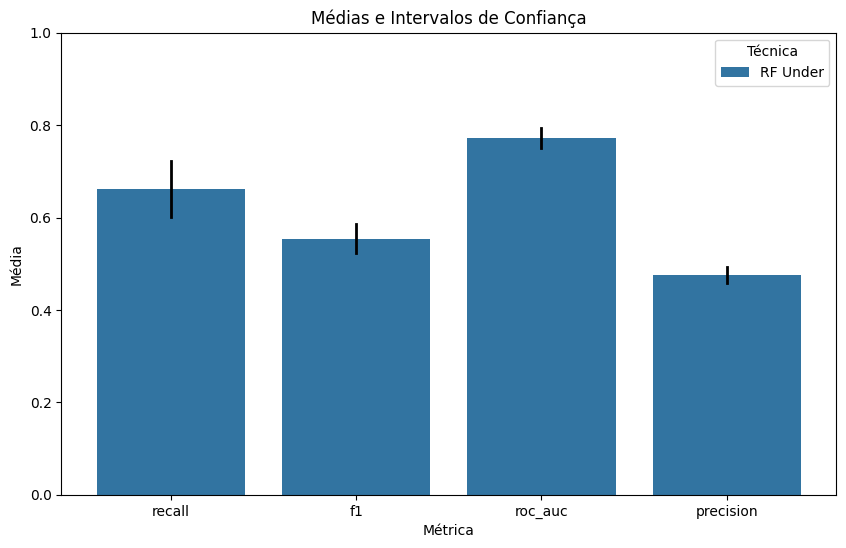


--- DecisionTree Oversampling (Inicial) ---
Recall: Média=0.5439, IC=[0.5143, 0.5734]
F1: Média=0.4784, IC=[0.4468, 0.5100]
Roc_auc: Média=0.6521, IC=[0.6275, 0.6767]
Precision: Média=0.4271, IC=[0.3939, 0.4602]


/tmp/ipython-input-3056284674.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_resultados, x='Métrica', y='Média', hue='Técnica', ci=None)


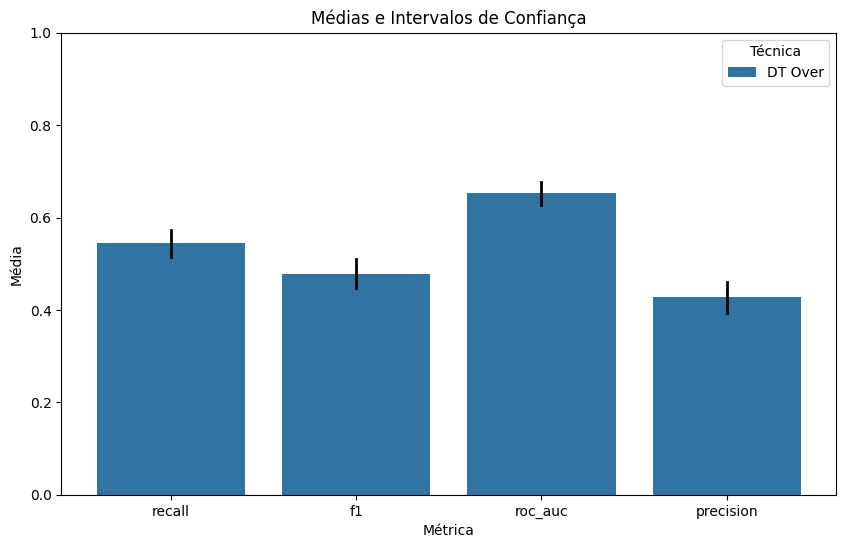


--- DecisionTree Undersampling (Inicial) ---
Recall: Média=0.6505, IC=[0.6226, 0.6784]
F1: Média=0.4914, IC=[0.4630, 0.5199]
Roc_auc: Média=0.6562, IC=[0.6299, 0.6826]
Precision: Média=0.3950, IC=[0.3658, 0.4242]


/tmp/ipython-input-3056284674.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_resultados, x='Métrica', y='Média', hue='Técnica', ci=None)


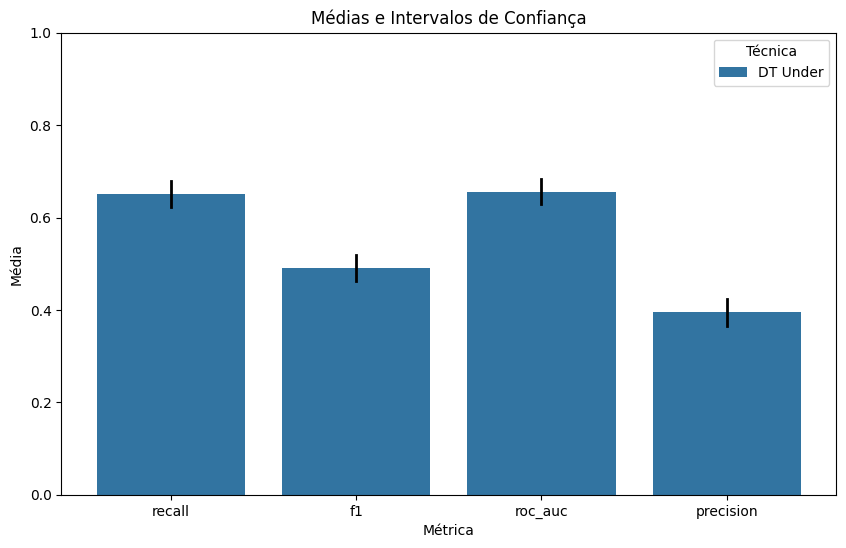

In [ ]:
# Avaliação inicial RandomForest
RF_Oversampling_resultados = cross_validate(
    pipeline_rf_oversample,
    X_train_selected, y_train,
    cv=skf, scoring=scoring, n_jobs=-1
)
RF_Undersampling_resultados = cross_validate(
    pipeline_rf_undersample,
    X_train_selected, y_train,
    cv=skf, scoring=scoring, n_jobs=-1
)

intervalo_conf(RF_Oversampling_resultados, "RandomForest Oversampling (Inicial)")
plot_intervalo_conf(intervalo_conf_df(RF_Oversampling_resultados, "RF Over", scoring))

intervalo_conf(RF_Undersampling_resultados, "RandomForest Undersampling (Inicial)")
plot_intervalo_conf(intervalo_conf_df(RF_Undersampling_resultados, "RF Under", scoring))

# Avaliação inicial DecisionTree
DT_Oversampling_resultados = cross_validate(
    pipeline_dt_oversample,
    X_train_selected, y_train,
    cv=skf, scoring=scoring, n_jobs=-1
)
DT_Undersampling_resultados = cross_validate(
    pipeline_dt_undersample,
    X_train_selected, y_train,
    cv=skf, scoring=scoring, n_jobs=-1
)

intervalo_conf(DT_Oversampling_resultados, "DecisionTree Oversampling (Inicial)")
plot_intervalo_conf(intervalo_conf_df(DT_Oversampling_resultados, "DT Over", scoring))

intervalo_conf(DT_Undersampling_resultados, "DecisionTree Undersampling (Inicial)")
plot_intervalo_conf(intervalo_conf_df(DT_Undersampling_resultados, "DT Under", scoring))

In [ ]:
# Parâmetros para GridSearch (RandomForest)
param_grid_rf = {
    'arvore__max_depth': [5, 10, 15],
    'arvore__min_samples_leaf': [1, 2, 3],
    'arvore__min_samples_split': [2, 4, 6],
    'arvore__n_estimators': [100, 150, 200]
}

# GridSearch com Oversampling
grid_search_rf_over = GridSearchCV(pipeline_rf_oversample, param_grid=param_grid_rf, cv=skf, scoring='f1', n_jobs=-1)
grid_search_rf_over.fit(X_train_selected, y_train)

# GridSearch com Undersampling
grid_search_rf_under = GridSearchCV(pipeline_rf_undersample, param_grid=param_grid_rf, cv=skf, scoring='f1', n_jobs=-1)
grid_search_rf_under.fit(X_train_selected, y_train)

# Exibição dos melhores resultados
print("\nRandomForest Oversampling - Melhores parâmetros:", grid_search_rf_over.best_params_)
print("Melhor F1 (CV):", grid_search_rf_over.best_score_)
print("\nRandomForest Undersampling - Melhores parâmetros:", grid_search_rf_under.best_params_)
print("Melhor F1 (CV):", grid_search_rf_under.best_score_)


RandomForest Oversampling - Melhores parâmetros: {'arvore__max_depth': 5, 'arvore__min_samples_leaf': 1, 'arvore__min_samples_split': 6, 'arvore__n_estimators': 150}
Melhor F1 (CV): 0.5897973998546472

RandomForest Undersampling - Melhores parâmetros: {'arvore__max_depth': 5, 'arvore__min_samples_leaf': 2, 'arvore__min_samples_split': 2, 'arvore__n_estimators': 100}
Melhor F1 (CV): 0.6002852397885388



--- Relatório de Classificação (RandomForest Undersampling Otimizado) ---
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1610
           1       0.53      0.65      0.58       547

    accuracy                           0.76      2157
   macro avg       0.70      0.73      0.71      2157
weighted avg       0.78      0.76      0.77      2157



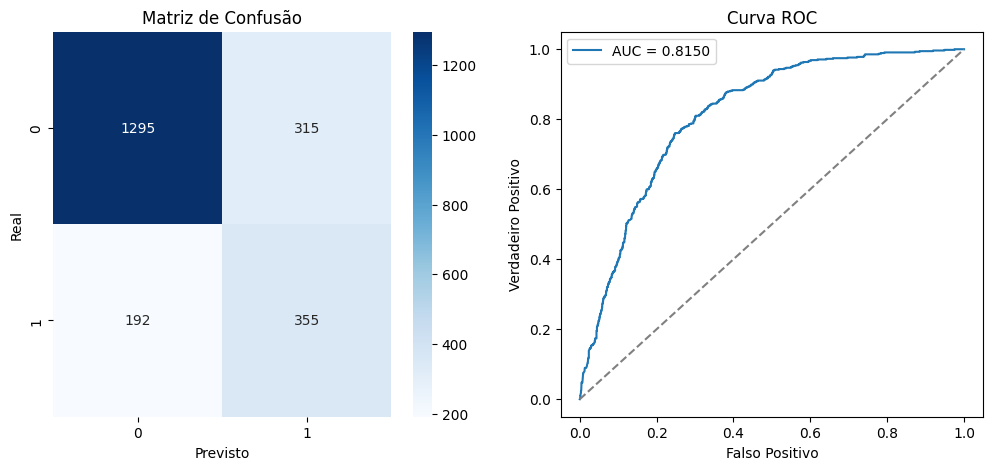

In [ ]:
# AVALIAÇÃO DO MELHOR MODELO (RF Undersampling Otimizado) NO CONJUNTO DE TESTE
best_model_rf_under = grid_search_rf_under.best_estimator_
y_pred_under = best_model_rf_under.predict(X_test_selected)

print("\n--- Relatório de Classificação (RandomForest Undersampling Otimizado) ---")
print(classification_report(y_test, y_pred_under))

# Plotagem da Matriz de Confusão e Curva ROC
plot_confusion_matrix_and_roc(best_model_rf_under, X_test_selected, y_test)

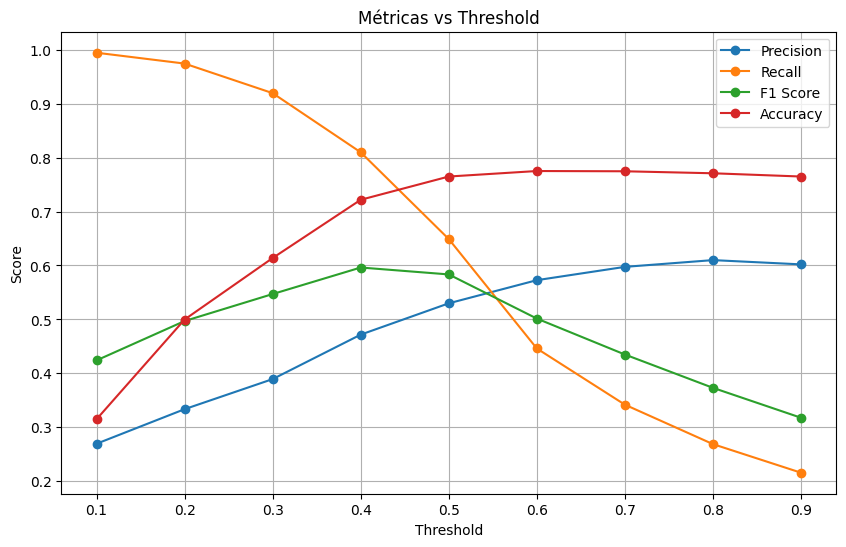


Resultados de Métricas por Threshold:
   threshold  precision    recall  f1_score  accuracy
0        0.1   0.269440  0.994516  0.424006  0.314789
1        0.2   0.333542  0.974406  0.496970  0.499768
2        0.3   0.389319  0.919561  0.547036  0.613815
3        0.4   0.471778  0.809872  0.596231  0.721836
4        0.5   0.529851  0.648995  0.583402  0.764951
5        0.6   0.572770  0.446069  0.501542  0.775151
6        0.7   0.597444  0.341865  0.434884  0.774687
7        0.8   0.609959  0.268739  0.373096  0.770978
8        0.9   0.602041  0.215722  0.317631  0.764951


In [ ]:
# Avaliação de Múltiplos Thresholds para Otimização
df_thresholds = avaliar_varios_thresholds(best_model_rf_under, X_test_selected, y_test)
print("\nResultados de Métricas por Threshold:")
print(df_thresholds)

In [ ]:
# O melhor modelo é o pipeline otimizado com Undersampling
best_pipeline = grid_search_rf_under.best_estimator_

# Define o nome do arquivo
NOME_ARQUIVO = 'melhor_modelo.pkl'

# Salva o pipeline completo em um arquivo pickle
with open(NOME_ARQUIVO, 'wb') as file:
    pickle.dump(best_pipeline, file)

print(f"Modelo salvo localmente como {NOME_ARQUIVO}.")
print("Agora, faça o upload deste arquivo para o seu repositório do GitHub.")

Modelo salvo localmente como melhor_modelo.pkl.
Agora, faça o upload deste arquivo para o seu repositório do GitHub.


# **Teste o desempenho do melhor modelo**


In [3]:
import pandas as pd
import numpy as np
import pickle
from urllib.request import urlopen

github_raw_url = 'https://raw.githubusercontent.com/KaikeGM/Challenge-Telecom-X-Data-Science-Parte-2/main/melhor_modelo.pkl'

# --- VARIÁVEIS DE CONFIGURAÇÃO DO MODELO ---
# As 10 features mais importantes usadas no treinamento:
top_features = ['Tenure', 'Charges.Total', 'Charges.Monthly', 'Contract_month-to-month',
                'OnlineSecurity_no', 'Contract_two year', 'TechSupport_no',
                'InternetService_fiber optic', 'PaymentMethod_electronic check',
                'PaperlessBilling']
# Threshold otimizado (0.4) para o melhor F1-Score
churn_threshold = 0.4
binary_map = {'yes': 1, 'no': 0}

# Faixas de valores numéricos dos dados de treinamento
ranges = {
    'Charges.Monthly': {'min': 18.25, 'max': 118.75},
    'Charges.Total': {'min': 18.80, 'max': 8684.80}
}

# Mapeamento para simular o One-Hot Encoding (OHE) do treinamento
ohe_map = {
    'Contract': ['month-to-month', 'one year', 'two year'],
    'PaymentMethod': ['bank transfer (automatic)', 'credit card (automatic)', 'electronic check', 'mailed check'],
    'InternetService': ['dsl', 'fiber optic', 'no'],
    'OnlineSecurity': ['no', 'yes', 'no internet service'],
    'TechSupport': ['no', 'yes', 'no internet service'],
    'StreamingTV': ['no', 'yes', 'no internet service'],
    'StreamingMovies': ['no', 'yes', 'no internet service'],
}

# --- FUNÇÃO DE CARREGAMENTO E PREVISÃO ---

def carregar_modelo_do_github(url):
    """Carrega o modelo serializado do GitHub via URL Raw."""
    try:
        print("Carregando modelo treinado do GitHub...")
        # Usa a URL bruta
        response = urlopen(url)
        modelo = pickle.load(response)
        print("Modelo carregado com sucesso!")
        return modelo
    except Exception as e:
        print(f"Erro ao carregar o modelo do GitHub: {e}")
        print("Verifique se o arquivo 'melhor_modelo.pkl' realmente existe na raiz do seu repositório 'main'.")
        return None

def coletar_dados_cliente():
    """Coleta os dados do cliente de forma interativa, mostrando as faixas de valores."""
    print("--- Digite os dados do cliente para a previsão: ---")

    dados = {}

    # Numéricas com Faixas
    dados['Charges.Monthly'] = float(input(f"Gasto Mensal (Charges.Monthly) [min: {ranges['Charges.Monthly']['min']} | max: {ranges['Charges.Monthly']['max']}]: "))
    dados['Charges.Total'] = float(input(f"Gasto Total Acumulado (Charges.Total) [min: {ranges['Charges.Total']['min']} | max: {ranges['Charges.Total']['max']}]: "))

    # Categóricas
    dados['Contract'] = input("Tipo de Contrato (month-to-month, one year, two year): ").lower().strip()
    dados['PaymentMethod'] = input("Método de Pagamento (bank transfer (automatic), credit card (automatic), electronic check, mailed check): ").lower().strip()
    dados['PaperlessBilling'] = input("Fatura sem papel? (yes/no): ").lower().strip()
    dados['InternetService'] = input("Serviço de Internet (dsl, fiber optic, no): ").lower().strip()
    dados['OnlineSecurity'] = input("Segurança Online? (yes/no/no internet service): ").lower().strip()
    dados['TechSupport'] = input("Suporte Técnico? (yes/no/no internet service): ").lower().strip()
    dados['StreamingTV'] = input("Streaming TV? (yes/no/no internet service): ").lower().strip()
    dados['StreamingMovies'] = input("Streaming Movies? (yes/no/no internet service): ").lower().strip()

    return dados

def prever_churn_interativo(modelo):
    """Executa a coleta de dados, pré-processamento e previsão."""
    try:
        dados_cliente = coletar_dados_cliente()
        df_input = pd.DataFrame([dados_cliente])

        # 1. FEATURE ENGINEERING (Tenure)
        df_input['Charges.Monthly'] = pd.to_numeric(df_input['Charges.Monthly'], errors='coerce')
        df_input['Charges.Total'] = pd.to_numeric(df_input['Charges.Total'], errors='coerce')

        if df_input['Charges.Monthly'].iloc[0] == 0:
            df_input['Tenure'] = 0.0
        else:
            df_input['Tenure'] = df_input['Charges.Total'] / df_input['Charges.Monthly']

        # 2. ENCODING BINÁRIO (PaperlessBilling)
        df_input['PaperlessBilling'] = df_input['PaperlessBilling'].apply(lambda x: binary_map.get(x, 0))

        # 3. ENCODING CATEGÓRICO (OHE Manual)
        df_encoded = df_input.copy()

        for col, values in ohe_map.items():
            if col in df_encoded.columns:
                for val in values:
                    col_name = f'{col}_{val}'
                    df_encoded[col_name] = np.where(df_encoded[col] == val, 1, 0)
                df_encoded = df_encoded.drop(columns=[col])

        # 4. SELEÇÃO E ORDENAÇÃO DAS TOP FEATURES
        for feature in top_features:
            if feature not in df_encoded.columns:
                df_encoded[feature] = 0

        df_final = df_encoded[top_features]

        # 5. PREDIÇÃO
        prob_churn = modelo.predict_proba(df_final)[:, 1][0]
        previsao_final = 1 if prob_churn >= churn_threshold else 0

        print("\n--- RESULTADO DA PREVISÃO ---")
        print(f"Probabilidade de Churn: {(prob_churn * 100):.2f}%")
        print(f"Decisão (Threshold {churn_threshold}): {'ALTO RISCO DE CHURN' if previsao_final == 1 else 'BAIXO RISCO DE CHURN'}")

        if previsao_final == 1:
            print("Recomendação: O cliente deve ser incluído em uma campanha proativa de retenção (Recall Alto).")
        else:
            print("Recomendação: Monitorar, mas nenhuma ação de retenção imediata é necessária.")

    except Exception as e:
        print(f"\nOcorreu um erro durante a previsão: {e}")
        print("Verifique se os valores inseridos estão no formato esperado (Numérico/Categórico).")


# --- FLUXO PRINCIPAL ---
modelo_carregado = carregar_modelo_do_github(github_raw_url)

if modelo_carregado:
    print("\n--- INÍCIO DO TESTE INTERATIVO ---")
    prever_churn_interativo(modelo_carregado)

Carregando modelo treinado do GitHub...
Modelo carregado com sucesso!

--- INÍCIO DO TESTE INTERATIVO ---
--- Digite os dados do cliente para a previsão: ---
Gasto Mensal (Charges.Monthly) [min: 18.25 | max: 118.75]: 75
Gasto Total Acumulado (Charges.Total) [min: 18.8 | max: 8684.8]: 4673
Tipo de Contrato (month-to-month, one year, two year): two year
Método de Pagamento (bank transfer (automatic), credit card (automatic), electronic check, mailed check): credit card (automatic)
Fatura sem papel? (yes/no): yes
Serviço de Internet (dsl, fiber optic, no): dsl
Segurança Online? (yes/no/no internet service): no
Suporte Técnico? (yes/no/no internet service): no
Streaming TV? (yes/no/no internet service): yes
Streaming Movies? (yes/no/no internet service): no

--- RESULTADO DA PREVISÃO ---
Probabilidade de Churn: 20.56%
Decisão (Threshold 0.4): BAIXO RISCO DE CHURN
Recomendação: Monitorar, mas nenhuma ação de retenção imediata é necessária.
